In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
"""Data Augmentation"""
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    
                                    )

train = train_data_gen.flow_from_directory(directory= './Data/Train',
                                           class_mode = 'binary',
                                           batch_size=64,
                                           target_size=(224,224))

Found 11047 images belonging to 2 classes.


In [4]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= './Data/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= './Data/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

Found 1377 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.


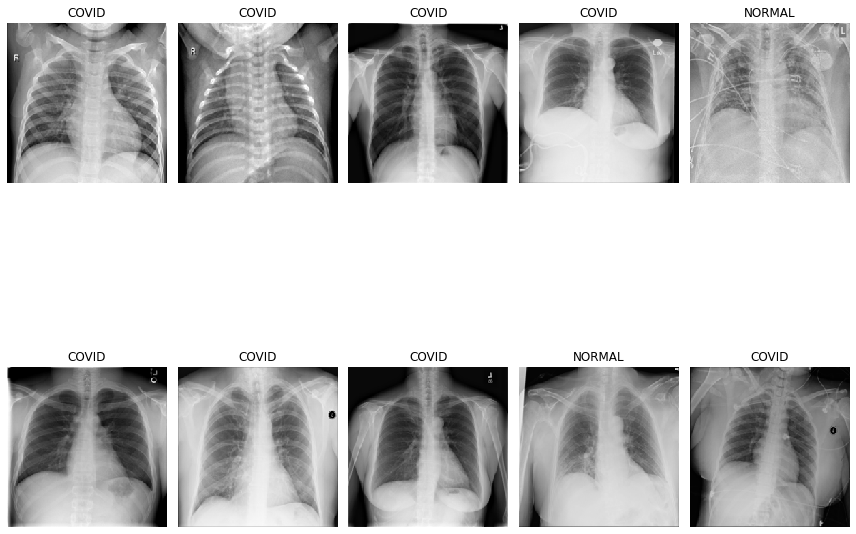

In [5]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [6]:
inc = tf.keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid'
)

In [7]:
for layer in inc.layers:           
    layer.trainable = False

In [8]:
'''
Definition of the Keras model outputs
'''

x = Flatten()(inc.output)
d1 = Dense(1024, activation= 'relu')(x)
dr1 = Dropout(0.25)(d1)
d2 = Dense(1024, activation= 'relu')(dr1)
dr2 = Dropout(0.25)(d2)
prediction= Dense(units=1 , activation='sigmoid')(d2)

model = Model(inc.input,prediction)

In [9]:
"""
Compile model
"""

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [10]:
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [11]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9092637400622192, 1: 0.6773975962717684}


C:\Users\amara\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [12]:
hist = model.fit(train, steps_per_epoch= len(train), epochs= 15, validation_data= valid,class_weight=cw,validation_steps= len(test), callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/15
173/173 [==============================] - 292s 2s/step - loss: 2.4826 - accuracy: 0.8156 - val_loss: 0.2551 - val_accuracy: 0.9256
Epoch 2/15
173/173 [==============================] - 259s 1s/step - loss: 0.2493 - accuracy: 0.9059 - val_loss: 0.4460 - val_accuracy: 0.7868
Epoch 3/15
173/173 [==============================] - 259s 1s/step - loss: 0.2593 - accuracy: 0.8909 - val_loss: 0.2115 - val_accuracy: 0.9314
Epoch 4/15
173/173 [==============================] - 259s 1s/step - loss: 0.2073 - accuracy: 0.9202 - val_loss: 0.1894 - val_accuracy: 0.9299
Epoch 5/15
173/173 [==============================] - 259s 1s/step - loss: 0.1720 - accuracy: 0.9352 - val_loss: 0.1371 - val_accuracy: 0.9494


<AxesSubplot:>

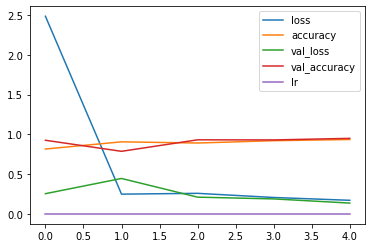

In [13]:
pd.DataFrame(hist.history).plot()

In [14]:
import seaborn as sns

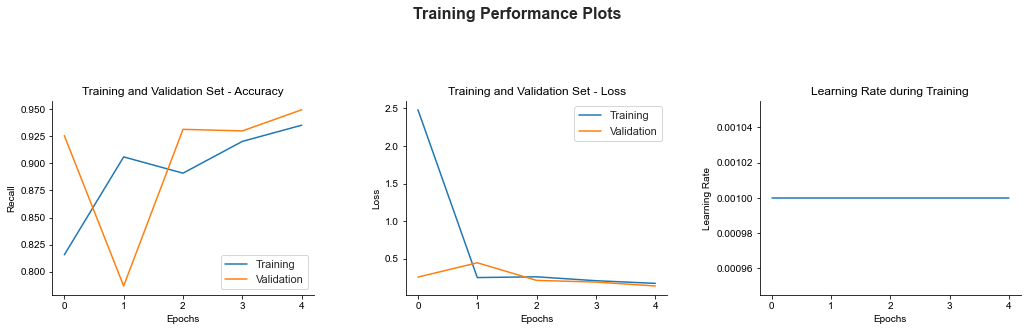

In [15]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(hist.history)

ax = sns.lineplot(x =historyDF.index, y = hist.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = hist.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = hist.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [16]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

22/22 [==============================] - 32s 1s/step - loss: 0.1628 - accuracy: 0.9339
The testing accuracy is : 93.3914303779602 %


In [17]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

22/22 [==============================] - 30s 1s/step


<AxesSubplot:>

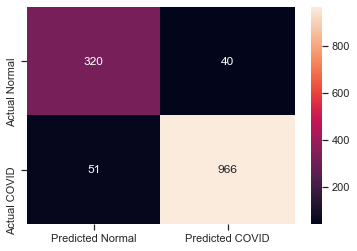

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual COVID"],
columns=["Predicted Normal", "Predicted COVID"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [19]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID']))

              precision    recall  f1-score   support

      NORMAL       0.86      0.89      0.88       360
       COVID       0.96      0.95      0.96      1017

    accuracy                           0.93      1377
   macro avg       0.91      0.92      0.92      1377
weighted avg       0.93      0.93      0.93      1377



In [20]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(1377, 224, 224, 3)
(1377,)


In [21]:
y_true=test.classes

In [22]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

**Overall Results**
Accuracy Result: 93.39%
Precision Result: 96.02%
Recall Result: 94.99%
F-Score Result: 95.50%


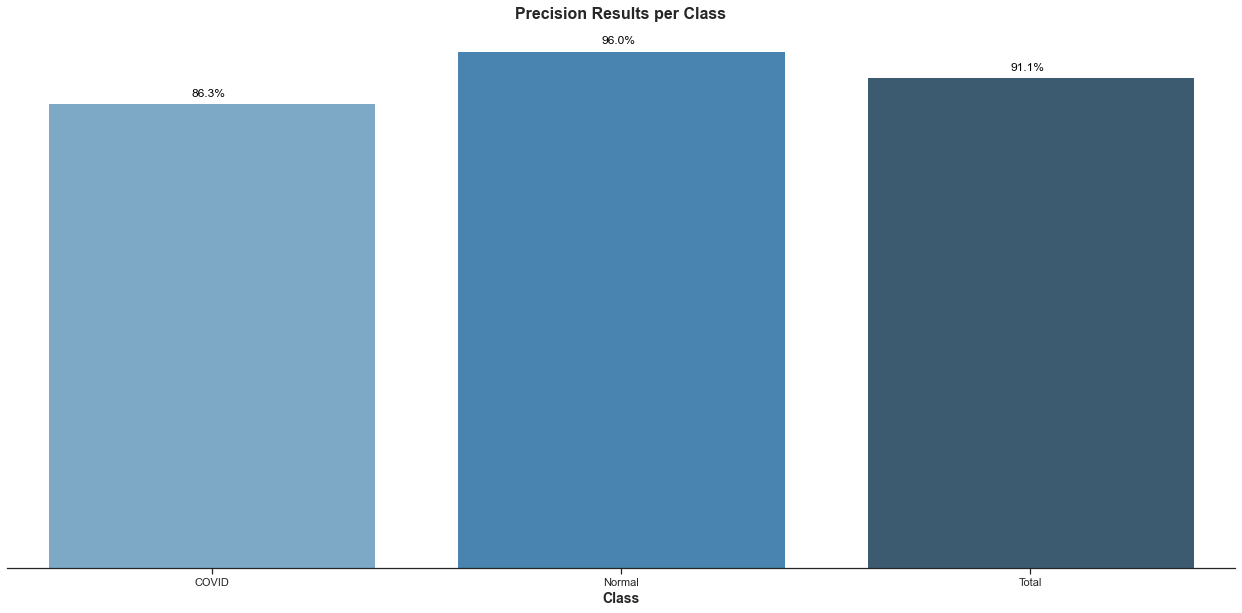

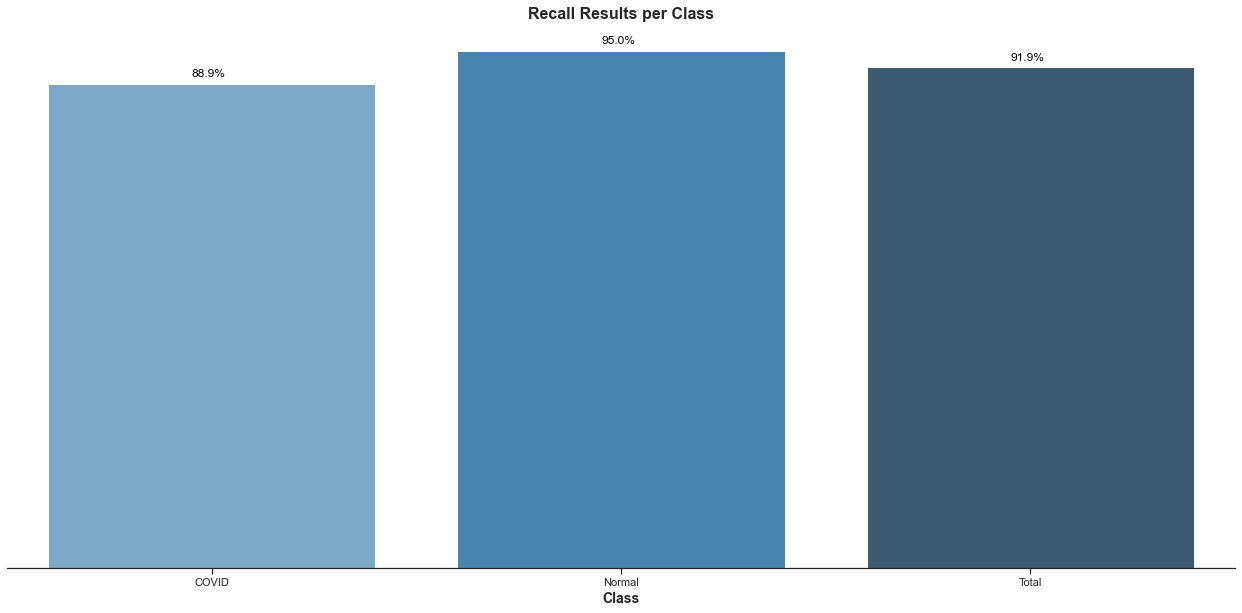

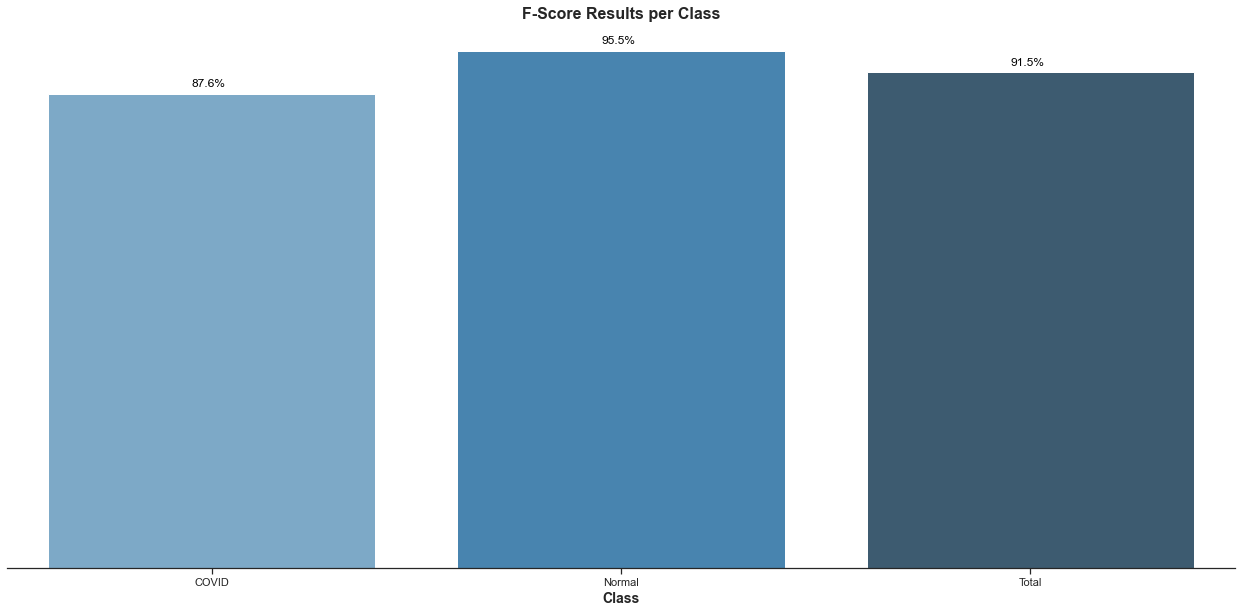

In [23]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

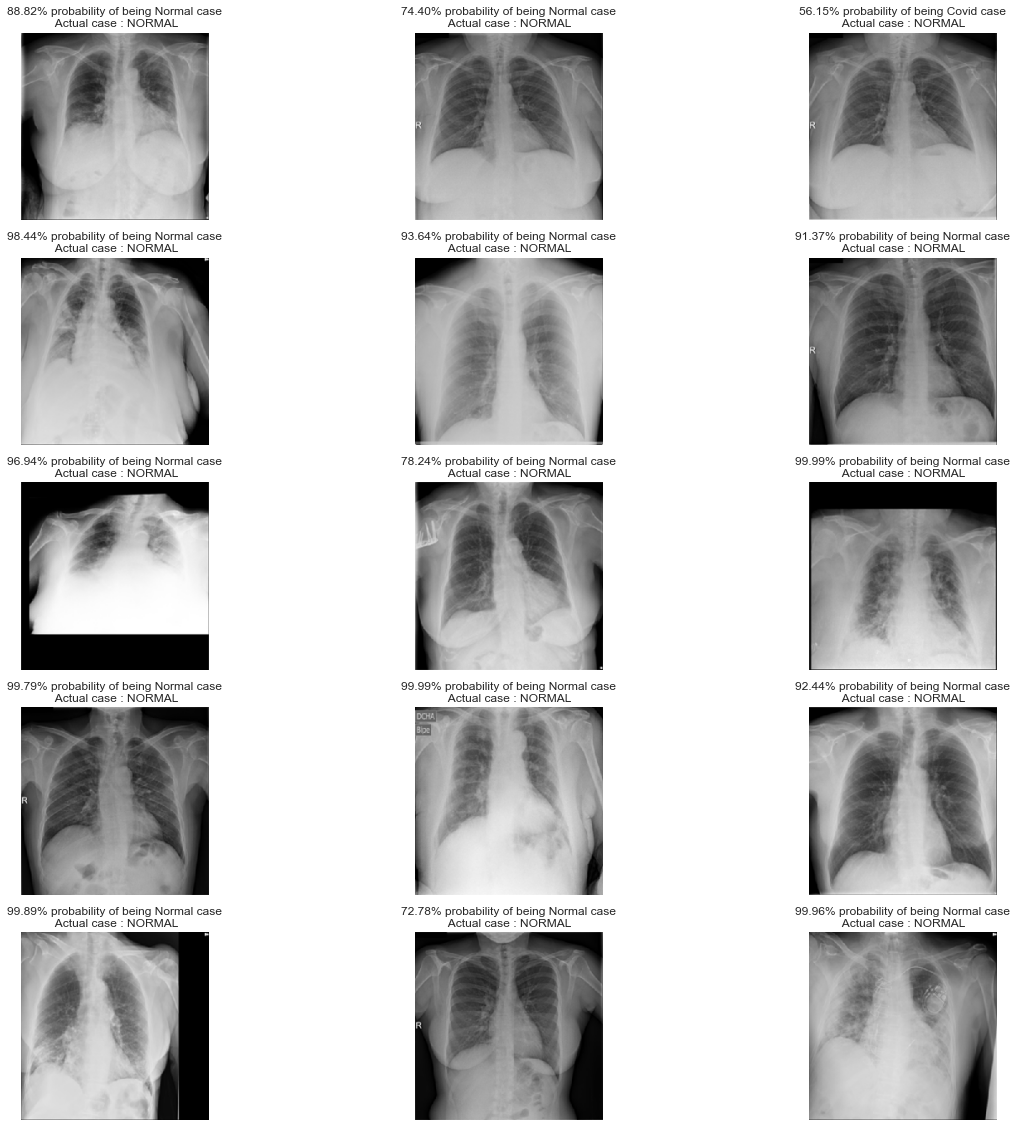

In [24]:
dic = {0:'NORMAL', 1:'COVID'}
plt.figure(figsize=(20,20))
for i in range(0+224, 15+224):
    plt.subplot(5,3, (i-224)+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} probability of being Covid case'.format(preds[i][0]))
      
      
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

    plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
plt.show()

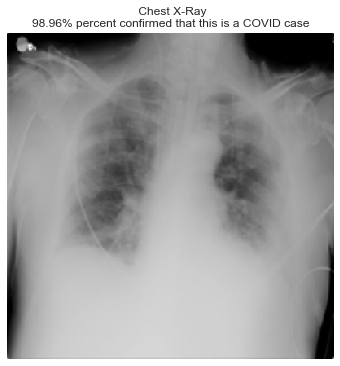

In [25]:
# Testing with random Chest X-Ray
img_path = '../datasets/COVID-19_Radiography_Dataset/COVID/COVID-1.png'
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(224,224))

# Preprocessing the image
pp_img = image.img_to_array(img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)

#predict
preds= model.predict(pp_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(preds[0][0]))
    
else: 
    out = ('{:.2%} percent confirmed that this is a COVID case'.format(1-preds[0][0]))
    

plt.title(" Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()

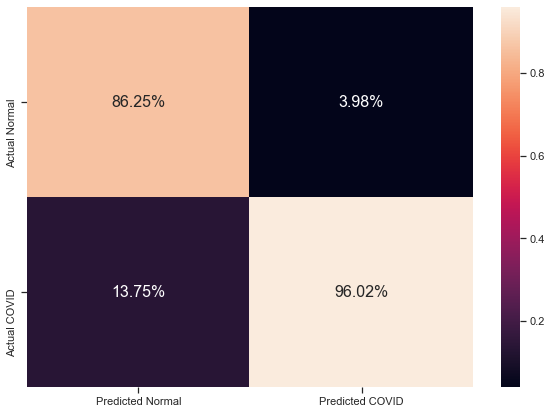

In [26]:
df_cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual COVID"],
columns=["Predicted Normal", "Predicted COVID"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot = True, annot_kws={'size':16})
plt.show()

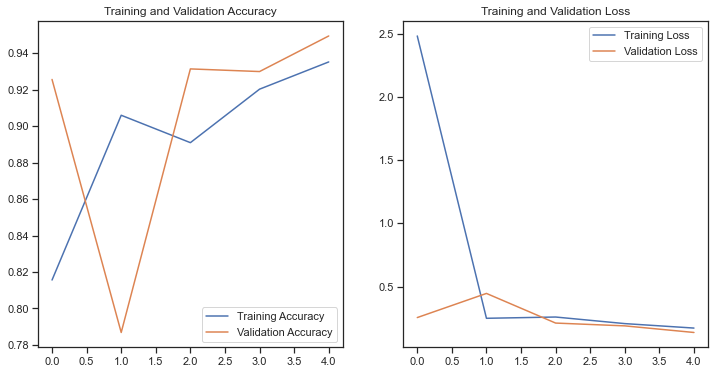

In [27]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()